In [11]:
import torch
import torch.nn as nn

import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data

import torchvision
import torchvision.models as models
from torchvision import transforms, datasets

from PIL import Image
import matplotlib.pyplot as plt

device = ("cuda" if torch.cuda.is_available() else "cpu") # Use GPU or CPU for training

Download models which are pretrained on the ImageNet dataset.
Next step is to replace the classifier with the number of classes that we want to predict instead of the number used for the ImageNet dataset.

In [12]:
model = torch.hub.load('pytorch/vision', 'resnet18', pretrained=True)

for name, param in model.named_parameters():
  param.requires_grad = False

Using cache found in /root/.cache/torch/hub/pytorch_vision_master


Next step is to replace the classifier with the number of classes that we want to predict instead of the number used for the ImageNet dataset.

In [13]:
num_classes = 2

model.fc = nn.Sequential(nn.Linear(model.fc.in_features, 512),
                                  nn.ReLU(),
                                  nn.Dropout(),
                                  nn.Linear(512, num_classes))

Before re-training the model we need to download and load our dataset.

In [14]:
import os
import zipfile

!wget "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"

with zipfile.ZipFile("./cats_and_dogs_filtered.zip","r") as zip_ref:
    zip_ref.extractall()

base_dir = './cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

--2020-08-06 14:22:25--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 142.250.1.128, 173.194.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip.1’

cats_and_dogs_filte 100%[===================>]  65.43M   218MB/s    in 0.3s    

2020-08-06 14:22:25 (218 MB/s) - ‘cats_and_dogs_filtered.zip.1’ saved [68606236/68606236]



In [15]:
data_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ])

train_data = datasets.ImageFolder(root=train_dir, transform=data_transforms)
validation_data = datasets.ImageFolder(root=validation_dir, transform=data_transforms)

# Get the size of our data, which will be used when calculating the average loss and accuracy
train_data_size = len(train_data)
valid_data_size = len(validation_data)

print(train_data_size)
print(valid_data_size)

# Used to import our dataset
trainLoader = torch.utils.data.DataLoader(dataset=train_data, batch_size=32, shuffle=True)
validationLoader = torch.utils.data.DataLoader(dataset=validation_data, batch_size=32, shuffle=True)

2000
1000


Define our optimizer and our loss function.

In [16]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Now we can train our model. We already did this in the previous posts so we will not get into great details here.

In [17]:
epochs = 20
train_loss, val_loss = [], []

for epoch in range(epochs):

  total_train_loss = 0
  total_validation_loss = 0

  model.train()

  for idx, (image, label) in enumerate(trainLoader):
    
    image, label = image.to(device), label.to(device)
    optimizer.zero_grad()
    pred = model(image)

    loss = criterion(pred, label)
    total_train_loss += loss.item()

    loss.backward()
    optimizer.step()

  total_train_loss /= (idx+1)
  train_loss.append(total_train_loss)

  model.eval()
  total = 0

  for idx, (image, label) in enumerate(validationLoader):

    image, label = image.to(device), label.to(device)
    pred = model(image)

    loss = criterion(pred, label)
    total_validation_loss += loss.item()

    pred = F.softmax(pred, dim=1)
    for i, p in enumerate(pred):
      if label[i] == torch.max(p.data, 0)[1]:
        total += 1
  
  accuracy = total / valid_data_size
  total_validation_loss /= (idx+1)
  val_loss.append(total_validation_loss)

  if epoch % 5 == 0:
    print('\nEpoch: {}/{}, Train Loss: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.4f}'.format(epoch, epochs, total_train_loss, total_validation_loss, accuracy))


Epoch: 0/20, Train Loss: 0.2412, Val Loss: 0.0681, Val Acc: 0.9780

Epoch: 5/20, Train Loss: 0.1267, Val Loss: 0.1165, Val Acc: 0.9480

Epoch: 10/20, Train Loss: 0.0609, Val Loss: 0.0665, Val Acc: 0.9700

Epoch: 15/20, Train Loss: 0.0572, Val Loss: 0.0682, Val Acc: 0.9730


To see how our model classifies we will plot the images and the predictions which our model made. If it got it correct the letters will be in blue color and if not in red.

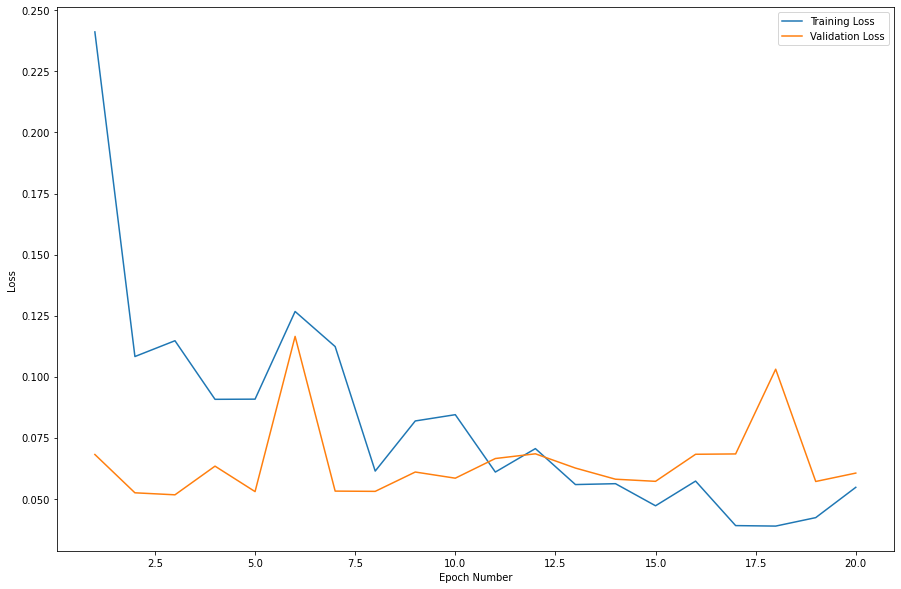

In [18]:
fig=plt.figure(figsize=(15, 10))
plt.plot(torch.arange(1, epochs+1), train_loss, label="Train loss")
plt.plot(torch.arange(1, epochs+1), val_loss, label="Validation loss")
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.title("")
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')

In [23]:
images, labels = next(iter(validationLoader))

In [24]:
with torch.no_grad():
  images, labels = images.to(device), labels.to(device)
  preds = model(images)

In [25]:
images_np = [i.mean(dim=0).cpu().numpy() for i in images]

class_names = ['Cat', 'Dog']

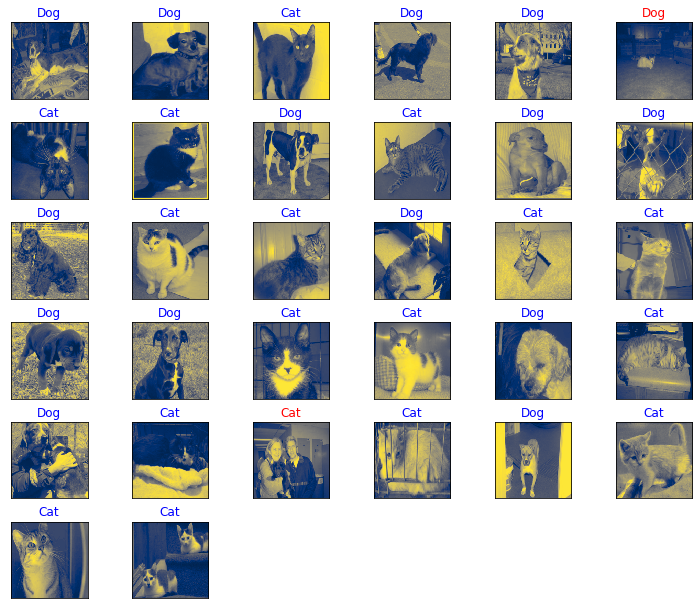

In [26]:
fig = plt.figure(figsize=(10, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.3, wspace=0.05)

for i in range(32):
    ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(images_np[i], cmap='cividis', interpolation='nearest')
    color = "blue" if labels[i] == torch.max(preds[i], 0)[1] else "red"
    plt.title(class_names[torch.max(preds[i], 0)[1]], color=color)